In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=42

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitor_sma1', 'station_visitors_mean', 'all_count_y1', 'all_count_y5'])
len(lag_cols)

14

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['nb_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'nb_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstmnb4", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
j

4

In [27]:
validpreds={}

In [28]:
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3002nb_lstm_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 5803 records out of 5803 records
no valid set
1505
0
14 18 (1, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 72s 48ms/step - loss: 2.0436 - total_loss: 2.0436 - reg_loss: 0.3752 - val_loss: 2.0217 - val_total_loss: 2.0217 - val_reg_loss: 0.2813
Epoch 2/100
1505/1505 [==============================] - 69s 46ms/step - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2991 - val_loss: 2.0208 - val_total_loss: 2.0208 - val_reg_loss: 0.2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883344  0.045766  0.232784    7  2017-04-16
472     2.507290  2.540544 -0.033254  0.223351    1  2017-04-17
473     2.661330  2.681689 -0.020360  0.245269    2  2017-04-18
474     2.754815  2.779387 -0.024573  0.200413    3  2017-04-19
475     2.713762  2.732787 -0.019026  0.235217    4  2017-04-20
476     2.999000  2.985893  0.013107  0.155999    5  2017-04-21
477     3.075529  3.098099 -0.022570  0.181650    6  2017-04-22

0.210668980583
best_epochs [18, 10, 9, 11, 14]
(829, 1) 2.70224156135 

2
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 6632 records out of 6632 records
no valid set
1505
0
14 18 (2, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 47ms/step - loss: 2.0650 - total_loss: 2.0650 - reg_loss: 0.3714 - val_loss: 2.0288 - val_total_loss: 2.0288 - val_reg_loss: 0.2746
Epoch 2/100
1505/1505 [==============================] - 69s 46ms/step - loss: 2.0427 - total_loss: 2.0427 - reg_loss: 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.878906  0.050204  0.240959    6  2017-04-15
471     2.507290  2.575127 -0.067837  0.239494    7  2017-04-16
472     2.661330  2.664283 -0.002954  0.253165    1  2017-04-17
473     2.754815  2.752646  0.002168  0.214161    2  2017-04-18
474     2.713762  2.758881 -0.045119  0.241220    3  2017-04-19
475     2.999000  2.997735  0.001265  0.161062    4  2017-04-20
476     3.075529  3.053764  0.021766  0.188191    5  2017-04-21

0.219750379253
best_epochs [15, 10, 14, 8, 13]
(829, 1) 2.56059883922 

3
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 7461 records out of 7461 records
no valid set
1505
0
14 18 (3, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 47ms/step - loss: 2.0608 - total_loss: 2.0608 - reg_loss: 0.3857 - val_loss: 2.0253 - val_total_loss: 2.0253 - val_reg_loss: 0.2871
Epoch 2/100
1505/1505 [==============================] - 69s 46ms/step - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.834835  0.094275  0.247035    5  2017-04-14
470     2.507290  2.539214 -0.031924  0.232724    6  2017-04-15
471     2.661330  2.627383  0.033946  0.263049    7  2017-04-16
472     2.754815  2.754772  0.000043  0.216746    1  2017-04-17
473     2.713762  2.744614 -0.030852  0.246371    2  2017-04-18
474     2.999000  3.006931 -0.007931  0.160620    3  2017-04-19
475     3.075529  3.047242  0.028287  0.189486    4  2017-04-20

0.222289930066
best_epochs [12, 14, 9, 15, 17]
(829, 1) 2.62099099156 

4
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 8290 records out of 8290 records
no valid set
1505
0
14 18 (4, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 46ms/step - loss: 2.0716 - total_loss: 2.0716 - reg_loss: 0.3871 - val_loss: 2.0226 - val_total_loss: 2.0226 - val_reg_loss: 0.2780
Epoch 2/100
1505/1505 [==============================] - 69s 46ms/step - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.861415  0.067695  0.247727    4  2017-04-13
469     2.507290  2.557369 -0.050079  0.237869    5  2017-04-14
470     2.661330  2.674074 -0.012744  0.260852    6  2017-04-15
471     2.754815  2.733657  0.021158  0.213383    7  2017-04-16
472     2.713762  2.779287 -0.065526  0.250684    1  2017-04-17
473     2.999000  3.020626 -0.021626  0.158788    2  2017-04-18
474     3.075529  3.091282 -0.015753  0.187332    3  2017-04-19

0.222376352127
best_epochs [12, 15, 17, 4, 10]
(829, 1) 2.75214802824 

5
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 9119 records out of 9119 records
no valid set
1505
0
14 18 (5, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 46ms/step - loss: 2.0415 - total_loss: 2.0415 - reg_loss: 0.3518 - val_loss: 2.0211 - val_total_loss: 2.0211 - val_reg_loss: 0.2706
Epoch 2/100
1505/1505 [==============================] - 56s 37ms/step - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.890154  0.038956  0.244253    3  2017-04-12
468     2.507290  2.574139 -0.066849  0.246331    4  2017-04-13
469     2.661330  2.703179 -0.041849  0.262613    5  2017-04-14
470     2.754815  2.717502  0.037312  0.220294    6  2017-04-15
471     2.713762  2.745709 -0.031947  0.247911    7  2017-04-16
472     2.999000  3.043098 -0.044098  0.162743    1  2017-04-17
473     3.075529  3.080015 -0.004486  0.188726    2  2017-04-18

0.224695831159
best_epochs [10, 13, 7, 12, 8]
(829, 1) 2.77364429854 

6
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 9948 records out of 9948 records
no valid set
1505
0
14 18 (6, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 46ms/step - loss: 2.0659 - total_loss: 2.0659 - reg_loss: 0.3814 - val_loss: 2.0174 - val_total_loss: 2.0174 - val_reg_loss: 0.2757
Epoch 2/100
1505/1505 [==============================] - 69s 46ms/step - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.911998  0.017112  0.245753    2  2017-04-11
467     2.507290  2.540428 -0.033138  0.245169    3  2017-04-12
468     2.661330  2.623179  0.038150  0.259365    4  2017-04-13
469     2.754815  2.715249  0.039566  0.213654    5  2017-04-14
470     2.713762  2.718988 -0.005226  0.241854    6  2017-04-15
471     2.999000  2.958516  0.040484  0.165893    7  2017-04-16
472     3.075529  3.091972 -0.016443  0.185066    1  2017-04-17

0.22239335067
best_epochs [9, 12, 17, 5, 14]
(829, 1) 2.98976223392 

7
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 10777 records out of 10777 records
no valid set
1505
0
14 18 (7, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.0616 - total_loss: 2.0616 - reg_loss: 0.3707 - val_loss: 2.0241 - val_total_loss: 2.0241 - val_reg_loss: 0.2714
Epoch 2/100
1505/1505 [==============================] - 53s 35ms/step - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.892499  0.036611  0.252660    1  2017-04-10
466     2.507290  2.595226 -0.087935  0.249965    2  2017-04-11
467     2.661330  2.655823  0.005507  0.270058    3  2017-04-12
468     2.754815  2.725408  0.029407  0.216255    4  2017-04-13
469     2.713762  2.731117 -0.017355  0.247610    5  2017-04-14
470     2.999000  2.987262  0.011738  0.162419    6  2017-04-15
471     3.075529  3.115877 -0.040348  0.197992    7  2017-04-16

0.228137072423
best_epochs [14, 12, 7, 17, 9]
(829, 1) 2.90389346614 

8
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 11606 records out of 11606 records
no valid set
1505
0
14 18 (8, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 47ms/step - loss: 2.0703 - total_loss: 2.0703 - reg_loss: 0.3613 - val_loss: 2.0316 - val_total_loss: 2.0316 - val_reg_loss: 0.2751
Epoch 2/100
1505/1505 [==============================] - 70s 46ms/step - loss: 2.0445 - total_loss: 2.0445 - reg_loss:

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.905350  0.023759  0.251444    7  2017-04-09
465     2.507290  2.584179 -0.076888  0.247869    1  2017-04-10
466     2.661330  2.659466  0.001864  0.274841    2  2017-04-11
467     2.754815  2.757401 -0.002586  0.226670    3  2017-04-12
468     2.713762  2.782454 -0.068693  0.258443    4  2017-04-13
469     2.999000  2.979622  0.019378  0.166815    5  2017-04-14
470     3.075529  3.088975 -0.013446  0.194008    6  2017-04-15

0.231441425807
best_epochs [12, 9, 13, 11, 19]
(829, 1) 2.71583829161 

9
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 12435 records out of 12435 records
no valid set
1505
0
14 18 (9, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 64s 42ms/step - loss: 2.0523 - total_loss: 2.0523 - reg_loss: 0.3667 - val_loss: 2.0295 - val_total_loss: 2.0295 - val_reg_loss: 0.2814
Epoch 2/100
1505/1505 [==============================] - 47s 31ms/step - loss: 2.0434 - total_loss: 2.0434 - reg_loss

best_epochs [9, 11, 15, 13, 4]
individual loss [ 0.25906266  0.25980295  0.25727595  0.25810603  0.26162653]
[ 0.26299204  0.01022884  0.23520726  0.33163122  0.15994065] 0.249600950164
best_epochs [9, 11, 15, 13, 4]
0.249600950168 0.249600950168
(1, 0.24960095016807271)
0.249600950168
best_epochs [9, 11, 15, 13, 4]
(12435, 1) 2.77088341848 (12435, 2)


y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.911924  0.017186  0.254240    6  2017-04-08
464     2.507290  2.577769 -0.070478  0.246329    7  2017-04-09
465     2.661330  2.687019 -0.025689  0.275577    1  2017-04-10
466     2.754815  2.750824  0.003991  0.232768    2  2017-04-11
467     2.713762  2.756810 -0.043048  0.257324    3  2017-04-12
468     2.999000  2.973222  0.025777  0.172080    4  2017-04-13
469     3.075529  3.091494 -0.015965  0.195083    5  2017-04-14

0.23334269358
best_epochs [9, 11, 15, 13, 4]
(829, 1) 2.61004669232 

10
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 13264 records out of 13264 records
no valid set
1505
0
14 18 (10, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 47ms/step - loss: 2.0508 - total_loss: 2.0508 - reg_loss: 0.3766 - val_loss: 2.0258 - val_total_loss: 2.0258 - val_reg_loss: 0.2911
Epoch 2/100
1505/1505 [==============================] - 69s 46ms/step - loss: 2.0407 - total_loss: 2.0407 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.889245  0.039865  0.252034    5  2017-04-07
463     2.507290  2.556066 -0.048776  0.248197    6  2017-04-08
464     2.661330  2.694877 -0.033547  0.279369    7  2017-04-09
465     2.754815  2.736139  0.018675  0.230049    1  2017-04-10
466     2.713762  2.758705 -0.044943  0.256559    2  2017-04-11
467     2.999000  2.976656  0.022344  0.168911    3  2017-04-12
468     3.075529  3.124374 -0.048845  0.194293    4  2017-04-13

0.232773164435
best_epochs [12, 13, 5, 9, 14]
(829, 1) 2.73178338379 

11
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 14093 records out of 14093 records
no valid set
1505
0
14 18 (11, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 70s 47ms/step - loss: 2.0842 - total_loss: 2.0842 - reg_loss: 0.3892 - val_loss: 2.0242 - val_total_loss: 2.0242 - val_reg_loss: 0.2968
Epoch 2/100
1505/1505 [==============================] - 70s 46ms/step - loss: 2.0379 - total_loss: 2.0379 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.876244  0.052866  0.253364    4  2017-04-06
462     2.507290  2.582767 -0.075476  0.253263    5  2017-04-07
463     2.661330  2.693815 -0.032485  0.276298    6  2017-04-08
464     2.754815  2.721368  0.033446  0.227844    7  2017-04-09
465     2.713762  2.782867 -0.069106  0.254067    1  2017-04-10
466     2.999000  2.961471  0.037529  0.170728    2  2017-04-11
467     3.075529  3.084964 -0.009435  0.196200    3  2017-04-12

0.233109111755
best_epochs [10, 6, 8, 14, 7]
(829, 1) 3.0541825856 

12
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 14922 records out of 14922 records
no valid set
1505
0
14 18 (12, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0711 - total_loss: 2.0711 - reg_loss: 0.3934 - val_loss: 2.0215 - val_total_loss: 2.0215 - val_reg_loss: 0.2847
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0364 - total_loss: 2.0364 - reg_loss:

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.864331  0.064779  0.252836    3  2017-04-05
461     2.507290  2.539980 -0.032689  0.245100    4  2017-04-06
462     2.661330  2.650578  0.010751  0.272320    5  2017-04-07
463     2.754815  2.724936  0.029878  0.228307    6  2017-04-08
464     2.713762  2.745098 -0.031337  0.249575    7  2017-04-09
465     2.999000  2.958886  0.040114  0.170692    1  2017-04-10
466     3.075529  3.071681  0.003848  0.197293    2  2017-04-11

0.230874718306
best_epochs [12, 9, 15, 11, 8]
(829, 1) 3.02600235991 

13
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 15751 records out of 15751 records
no valid set
1505
0
14 18 (13, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.0763 - total_loss: 2.0763 - reg_loss: 0.3783 - val_loss: 2.0187 - val_total_loss: 2.0187 - val_reg_loss: 0.2867
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0343 - total_loss: 2.0343 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.878491  0.050619  0.259946    2  2017-04-04
460     2.507290  2.537455 -0.030165  0.243638    3  2017-04-05
461     2.661330  2.683295 -0.021965  0.274417    4  2017-04-06
462     2.754815  2.735855  0.018960  0.225146    5  2017-04-07
463     2.713762  2.759167 -0.045405  0.250995    6  2017-04-08
464     2.999000  2.994163  0.004837  0.167308    7  2017-04-09
465     3.075529  3.071599  0.003930  0.198112    1  2017-04-10

0.23136614423
best_epochs [11, 16, 8, 10, 5]
(829, 1) 3.15755826776 

14
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 16580 records out of 16580 records
no valid set
1505
0
14 18 (14, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.0544 - total_loss: 2.0544 - reg_loss: 0.3627 - val_loss: 2.0243 - val_total_loss: 2.0243 - val_reg_loss: 0.2793
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0390 - total_loss: 2.0390 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.920112  0.008998  0.259291    1  2017-04-03
459     2.507290  2.577658 -0.070368  0.253594    2  2017-04-04
460     2.661330  2.669602 -0.008273  0.275705    3  2017-04-05
461     2.754815  2.723972  0.030842  0.230803    4  2017-04-06
462     2.713762  2.748343 -0.034581  0.248684    5  2017-04-07
463     2.999000  3.011244 -0.012244  0.163579    6  2017-04-08
464     3.075529  3.140668 -0.065139  0.204428    7  2017-04-09

0.233726242498
best_epochs [13, 9, 10, 11, 14]
(829, 1) 3.04880183307 

15
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 17409 records out of 17409 records
no valid set
1505
0
14 18 (15, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 32s 22ms/step - loss: 2.0584 - total_loss: 2.0584 - reg_loss: 0.3625 - val_loss: 2.0317 - val_total_loss: 2.0317 - val_reg_loss: 0.2864
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0445 - total_loss: 2.0445 - reg_lo

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.912356  0.016754  0.273560    7  2017-04-02
458     2.507290  2.554919 -0.047628  0.257127    1  2017-04-03
459     2.661330  2.666199 -0.004869  0.285908    2  2017-04-04
460     2.754815  2.733211  0.021604  0.236867    3  2017-04-05
461     2.713762  2.786258 -0.072496  0.264566    4  2017-04-06
462     2.999000  2.981156  0.017844  0.177116    5  2017-04-07
463     3.075529  3.108876 -0.033347  0.208142    6  2017-04-08

0.243326690526
best_epochs [10, 12, 11, 8, 15]
(829, 1) 2.71073665833 

16
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 18238 records out of 18238 records
no valid set
1505
0
14 18 (16, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.0619 - total_loss: 2.0619 - reg_loss: 0.3845 - val_loss: 2.0294 - val_total_loss: 2.0294 - val_reg_loss: 0.2897
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0437 - total_loss: 2.0437 - reg_lo

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.831239  0.097871  0.277246    6  2017-04-01
457     2.507290  2.560553 -0.053262  0.259512    7  2017-04-02
458     2.661330  2.664508 -0.003179  0.280256    1  2017-04-03
459     2.754815  2.761465 -0.006650  0.243720    2  2017-04-04
460     2.713762  2.767468 -0.053707  0.267302    3  2017-04-05
461     2.999000  2.954620  0.044380  0.176721    4  2017-04-06
462     3.075529  3.100574 -0.025045  0.199264    5  2017-04-07

0.243431733474
best_epochs [6, 14, 10, 8, 13]
(829, 1) 2.62772734042 

17
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 19067 records out of 19067 records
no valid set
1505
0
14 18 (17, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0553 - total_loss: 2.0553 - reg_loss: 0.3767 - val_loss: 2.0257 - val_total_loss: 2.0257 - val_reg_loss: 0.2991
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0408 - total_loss: 2.0408 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.944810 -0.015700  0.273106    5  2017-03-31
456     2.507290  2.610554 -0.103263  0.261941    6  2017-04-01
457     2.661330  2.679999 -0.018669  0.291349    7  2017-04-02
458     2.754815  2.771913 -0.017099  0.242186    1  2017-04-03
459     2.713762  2.789473 -0.075712  0.272377    2  2017-04-04
460     2.999000  3.022885 -0.023885  0.181114    3  2017-04-05
461     3.075529  3.109880 -0.034351  0.202431    4  2017-04-06

0.246357737362
best_epochs [13, 12, 7, 9, 4]
(829, 1) 2.71380813526 

18
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 19896 records out of 19896 records
no valid set
1505
0
14 18 (18, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.3778 - val_loss: 2.0239 - val_total_loss: 2.0239 - val_reg_loss: 0.3012
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0375 - total_loss: 2.0375 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.896173  0.032937  0.270920    4  2017-03-30
455     2.507290  2.550757 -0.043466  0.247196    5  2017-03-31
456     2.661330  2.653834  0.007496  0.284622    6  2017-04-01
457     2.754815  2.746602  0.008213  0.240436    7  2017-04-02
458     2.713762  2.766509 -0.052747  0.261763    1  2017-04-03
459     2.999000  2.980861  0.018139  0.179608    2  2017-04-04
460     3.075529  3.028946  0.046583  0.204410    3  2017-04-05

0.241279376654
best_epochs [12, 8, 14, 6, 11]
(829, 1) 2.79857296889 

19
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 20725 records out of 20725 records
no valid set
1505
0
14 18 (19, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0437 - total_loss: 2.0437 - reg_loss: 0.3705 - val_loss: 2.0218 - val_total_loss: 2.0218 - val_reg_loss: 0.2907
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0358 - total_loss: 2.0358 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.915074  0.014036  0.259657    3  2017-03-29
454     2.507290  2.618839 -0.111549  0.258787    4  2017-03-30
455     2.661330  2.708390 -0.047060  0.283995    5  2017-03-31
456     2.754815  2.765950 -0.011136  0.237355    6  2017-04-01
457     2.713762  2.758062 -0.044300  0.263695    7  2017-04-02
458     2.999000  2.998544  0.000456  0.178787    1  2017-04-03
459     3.075529  3.108431 -0.032902  0.204112    2  2017-04-04

0.240912566565
best_epochs [10, 9, 6, 13, 15]
(829, 1) 2.79761360227 

20
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 21554 records out of 21554 records
no valid set
1505
0
14 18 (20, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.0468 - total_loss: 2.0468 - reg_loss: 0.3814 - val_loss: 2.0190 - val_total_loss: 2.0190 - val_reg_loss: 0.2984
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0341 - total_loss: 2.0341 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.908308  0.020802  0.271278    2  2017-03-28
453     2.507290  2.581796 -0.074505  0.265453    3  2017-03-29
454     2.661330  2.676152 -0.014823  0.285121    4  2017-03-30
455     2.754815  2.712597  0.042218  0.241007    5  2017-03-31
456     2.713762  2.719244 -0.005483  0.266968    6  2017-04-01
457     2.999000  2.975586  0.023414  0.179448    7  2017-04-02
458     3.075529  3.106488 -0.030958  0.202979    1  2017-04-03

0.244607466351
best_epochs [9, 12, 8, 10, 6]
(829, 1) 2.94458947845 

21
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 22383 records out of 22383 records
no valid set
1505
0
14 18 (21, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0493 - total_loss: 2.0493 - reg_loss: 0.3663 - val_loss: 2.0241 - val_total_loss: 2.0241 - val_reg_loss: 0.2783
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0389 - total_loss: 2.0389 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.888704  0.040406  0.267908    1  2017-03-27
452     2.507290  2.581843 -0.074553  0.262774    2  2017-03-28
453     2.661330  2.668046 -0.006716  0.283902    3  2017-03-29
454     2.754815  2.733687  0.021128  0.235537    4  2017-03-30
455     2.713762  2.731945 -0.018183  0.266228    5  2017-03-31
456     2.999000  2.954105  0.044895  0.183525    6  2017-04-01
457     3.075529  3.127201 -0.051672  0.206438    7  2017-04-02

0.243758942417
best_epochs [17, 10, 8, 13, 14]
(829, 1) 3.0368739064 

22
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 23212 records out of 23212 records
no valid set
1505
0
14 18 (22, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0699 - total_loss: 2.0699 - reg_loss: 0.3756 - val_loss: 2.0317 - val_total_loss: 2.0317 - val_reg_loss: 0.2858
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0445 - total_loss: 2.0445 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.932777 -0.003667  0.269201    7  2017-03-26
451     2.507290  2.590335 -0.083044  0.257273    1  2017-03-27
452     2.661330  2.692542 -0.031212  0.280461    2  2017-03-28
453     2.754815  2.793988 -0.039173  0.240701    3  2017-03-29
454     2.713762  2.770980 -0.057218  0.269394    4  2017-03-30
455     2.999000  3.020264 -0.021264  0.179961    5  2017-03-31
456     3.075529  3.115542 -0.040013  0.205362    6  2017-04-01

0.243193403234
best_epochs [11, 15, 13, 17, 8]
(829, 1) 2.77993872482 

23
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 24041 records out of 24041 records
no valid set
1505
0
14 18 (23, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0719 - total_loss: 2.0719 - reg_loss: 0.4153 - val_loss: 2.0305 - val_total_loss: 2.0305 - val_reg_loss: 0.3070
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0439 - total_loss: 2.0439 - reg_lo

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.895509  0.033601  0.270663    6  2017-03-25
450     2.507290  2.537758 -0.030468  0.267968    7  2017-03-26
451     2.661330  2.706427 -0.045097  0.290070    1  2017-03-27
452     2.754815  2.740933  0.013882  0.246962    2  2017-03-28
453     2.713762  2.729592 -0.015831  0.272434    3  2017-03-29
454     2.999000  2.985364  0.013636  0.188596    4  2017-03-30
455     3.075529  3.064319  0.011211  0.204529    5  2017-03-31

0.248745995571
best_epochs [17, 12, 13, 10, 15]
(829, 1) 2.48600889685 

24
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 24870 records out of 24870 records
no valid set
1505
0
14 18 (24, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0461 - total_loss: 2.0461 - reg_loss: 0.3713 - val_loss: 2.0258 - val_total_loss: 2.0258 - val_reg_loss: 0.3022
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0401 - total_loss: 2.0401 - reg_l

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.889907  0.039203  0.274125    5  2017-03-24
449     2.507290  2.555266 -0.047975  0.261609    6  2017-03-25
450     2.661330  2.660112  0.001218  0.287934    7  2017-03-26
451     2.754815  2.757535 -0.002720  0.245861    1  2017-03-27
452     2.713762  2.783321 -0.069559  0.274620    2  2017-03-28
453     2.999000  2.981473  0.017526  0.183812    3  2017-03-29
454     3.075529  3.069597  0.005932  0.205710    4  2017-03-30

0.24766722424
best_epochs [7, 11, 12, 8, 4]
(829, 1) 2.58430465891 

25
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 25699 records out of 25699 records
no valid set
1505
0
14 18 (25, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0605 - total_loss: 2.0605 - reg_loss: 0.4096 - val_loss: 2.0240 - val_total_loss: 2.0240 - val_reg_loss: 0.3001
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0379 - total_loss: 2.0379 - reg_loss:

Epoch 22/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2377 - val_loss: 2.0230 - val_total_loss: 2.0230 - val_reg_loss: 0.2875
Epoch 23/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2312 - val_loss: 2.0245 - val_total_loss: 2.0245 - val_reg_loss: 0.2933
best_epochs [15, 12, 17, 13, 9]
individual loss [ 0.27076542  0.27216269  0.27228011  0.27523723  0.28422339]
[ 0.2371849   0.23174583  0.27727225  0.19710052  0.05669649] 0.265863872341
best_epochs [15, 12, 17, 13, 9]
0.265863872336 0.265863872336
(1, 0.26586387233633924)
0.265863872336
best_epochs [15, 12, 17, 13, 9]
(25699, 1) 2.74731855184 (25699, 2)


y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.842704  0.086406  0.280860    4  2017-03-23
448     2.507290  2.537003 -0.029712  0.264044    5  2017-03-24
449     2.661330  2.675639 -0.014310  0.281787    6  2017-03-25
450     2.754815  2.713849  0.040966  0.245407    7  2017-03-26
451     2.713762  2.704824  0.008938  0.265809    1  2017-03-27
452     2.999000  2.986696  0.012304  0.183248    2  2017-03-28
453     3.075529  3.020507  0.055022  0.208043    3  2017-03-29

0.247028435877
best_epochs [15, 12, 17, 13, 9]
(829, 1) 2.68587712874 

26
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 26528 records out of 26528 records
no valid set
1505
0
14 18 (26, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.9565 - total_loss: 2.9565 - reg_loss: 0.5794 - val_loss: 2.0221 - val_total_loss: 2.0221 - val_reg_loss: 0.3049
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0358 - total_loss: 2.0358 - reg_lo

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.921198  0.007912  0.261546    3  2017-03-22
447     2.507290  2.509851 -0.002561  0.255640    4  2017-03-23
448     2.661330  2.669056 -0.007727  0.279105    5  2017-03-24
449     2.754815  2.710560  0.044254  0.241495    6  2017-03-25
450     2.713762  2.724291 -0.010529  0.263476    7  2017-03-26
451     2.999000  2.994038  0.004962  0.179262    1  2017-03-27
452     3.075529  3.072997  0.002532  0.207533    2  2017-03-28

0.241150869483
best_epochs [18, 7, 12, 15, 9]
(829, 1) 2.6937033177 

27
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 27357 records out of 27357 records
no valid set
1505
0
14 18 (27, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 32s 21ms/step - loss: 2.0519 - total_loss: 2.0519 - reg_loss: 0.3860 - val_loss: 2.0197 - val_total_loss: 2.0197 - val_reg_loss: 0.3020
Epoch 2/100
1505/1505 [==============================] - 30s 20ms/step - loss: 2.0340 - total_loss: 2.0340 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.915464  0.013646  0.269056    2  2017-03-21
446     2.507290  2.557510 -0.050220  0.259507    3  2017-03-22
447     2.661330  2.687782 -0.026453  0.281992    4  2017-03-23
448     2.754815  2.743267  0.011548  0.238219    5  2017-03-24
449     2.713762  2.784431 -0.070670  0.273085    6  2017-03-25
450     2.999000  2.995405  0.003595  0.179774    7  2017-03-26
451     3.075529  3.075404  0.000125  0.205344    1  2017-03-27

0.243853931428
best_epochs [13, 16, 15, 8, 9]
(829, 1) 2.95597945964 

28
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 28186 records out of 28186 records
no valid set
1505
0
14 18 (28, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 31s 21ms/step - loss: 2.0542 - total_loss: 2.0542 - reg_loss: 0.3688 - val_loss: 2.0250 - val_total_loss: 2.0250 - val_reg_loss: 0.2901
Epoch 2/100
1505/1505 [==============================] - 29s 19ms/step - loss: 2.0385 - total_loss: 2.0385 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.855638  0.073472  0.282124    1  2017-03-20
445     2.507290  2.535318 -0.028028  0.260926    2  2017-03-21
446     2.661330  2.693193 -0.031864  0.279742    3  2017-03-22
447     2.754815  2.716665  0.038150  0.239943    4  2017-03-23
448     2.713762  2.767232 -0.053470  0.272050    5  2017-03-24
449     2.999000  2.984339  0.014661  0.178352    6  2017-03-25
450     3.075529  3.069944  0.005586  0.207835    7  2017-03-26

0.245853175825
best_epochs [16, 10, 12, 13, 7]
(829, 1) 3.0678065759 

29
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 29015 records out of 29015 records
no valid set
1505
0
14 18 (29, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 31s 20ms/step - loss: 2.0552 - total_loss: 2.0552 - reg_loss: 0.3679 - val_loss: 2.0321 - val_total_loss: 2.0321 - val_reg_loss: 0.2897
Epoch 2/100
1505/1505 [==============================] - 29s 20ms/step - loss: 2.0441 - total_loss: 2.0441 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.913014  0.016096  0.285027    7  2017-03-19
444     2.507290  2.602372 -0.095082  0.270842    1  2017-03-20
445     2.661330  2.676390 -0.015060  0.292454    2  2017-03-21
446     2.754815  2.704243  0.050572  0.255437    3  2017-03-22
447     2.713762  2.717191 -0.003429  0.273243    4  2017-03-23
448     2.999000  3.017880 -0.018880  0.192474    5  2017-03-24
449     3.075529  3.112048 -0.036518  0.220499    6  2017-03-25

0.255710863278
best_epochs [9, 8, 7, 12, 6]
(829, 1) 2.74249609813 

30
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 29844 records out of 29844 records
no valid set
1505
0
14 18 (30, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0568 - total_loss: 2.0568 - reg_loss: 0.3848 - val_loss: 2.0298 - val_total_loss: 2.0298 - val_reg_loss: 0.2993
Epoch 2/100
1505/1505 [==============================] - 42s 28ms/step - loss: 2.0432 - total_loss: 2.0432 - reg_loss:

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.935375 -0.006265  0.276249    6  2017-03-18
443     2.507290  2.574436 -0.067145  0.267359    7  2017-03-19
444     2.661330  2.682817 -0.021488  0.292659    1  2017-03-20
445     2.754815  2.733459  0.021356  0.254864    2  2017-03-21
446     2.713762  2.749410 -0.035649  0.276149    3  2017-03-22
447     2.999000  3.045128 -0.046129  0.188933    4  2017-03-23
448     3.075529  3.123069 -0.047540  0.213219    5  2017-03-24

0.252776007885
best_epochs [12, 7, 8, 6, 14]
(829, 1) 2.54135228106 

31
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 30673 records out of 30673 records
no valid set
1505
0
14 18 (31, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 31s 21ms/step - loss: 2.0979 - total_loss: 2.0979 - reg_loss: 0.4335 - val_loss: 2.0264 - val_total_loss: 2.0264 - val_reg_loss: 0.3058
Epoch 2/100
1505/1505 [==============================] - 30s 20ms/step - loss: 2.0406 - total_loss: 2.0406 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.924499  0.004611  0.271441    5  2017-03-17
442     2.507290  2.576715 -0.069425  0.259306    6  2017-03-18
443     2.661330  2.686110 -0.024781  0.289115    7  2017-03-19
444     2.754815  2.739382  0.015432  0.245415    1  2017-03-20
445     2.713762  2.710023  0.003739  0.273965    2  2017-03-21
446     2.999000  3.031557 -0.032557  0.189531    3  2017-03-22
447     3.075529  3.095635 -0.020106  0.207495    4  2017-03-23

0.248038352154
best_epochs [10, 12, 15, 13, 16]
(829, 1) 2.72356540215 

32
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 31502 records out of 31502 records
no valid set
1505
0
14 18 (32, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0690 - total_loss: 2.0690 - reg_loss: 0.3954 - val_loss: 2.0236 - val_total_loss: 2.0236 - val_reg_loss: 0.3063
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0375 - total_loss: 2.0375 - reg_l

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.950996 -0.021886  0.264861    4  2017-03-16
441     2.507290  2.575376 -0.068085  0.261389    5  2017-03-17
442     2.661330  2.705182 -0.043852  0.287687    6  2017-03-18
443     2.754815  2.752446  0.002369  0.241256    7  2017-03-19
444     2.713762  2.737561 -0.023800  0.264974    1  2017-03-20
445     2.999000  2.989367  0.009632  0.185707    2  2017-03-21
446     3.075529  3.078948 -0.003419  0.212372    3  2017-03-22

0.245463908166
best_epochs [10, 18, 7, 9, 14]
(829, 1) 2.80367390277 

33
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 32331 records out of 32331 records
no valid set
1505
0
14 18 (33, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.0430 - total_loss: 2.0430 - reg_loss: 0.3753 - val_loss: 2.0233 - val_total_loss: 2.0233 - val_reg_loss: 0.3185
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0355 - total_loss: 2.0355 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.844411  0.084699  0.280292    3  2017-03-15
440     2.507290  2.544961 -0.037670  0.263622    4  2017-03-16
441     2.661330  2.666936 -0.005606  0.291599    5  2017-03-17
442     2.754815  2.715634  0.039181  0.252330    6  2017-03-18
443     2.713762  2.772815 -0.059053  0.275191    7  2017-03-19
444     2.999000  2.992341  0.006658  0.189963    1  2017-03-20
445     3.075529  3.078951 -0.003422  0.214467    2  2017-03-21

0.252495164115
best_epochs [11, 8, 7, 10, 4]
(829, 1) 2.76432970193 

34
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 33160 records out of 33160 records
no valid set
1505
0
14 18 (34, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0493 - total_loss: 2.0493 - reg_loss: 0.3798 - val_loss: 2.0199 - val_total_loss: 2.0199 - val_reg_loss: 0.3010
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0340 - total_loss: 2.0340 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.979000 -0.049890  0.274139    2  2017-03-14
439     2.507290  2.611148 -0.103857  0.270509    3  2017-03-15
440     2.661330  2.687910 -0.026581  0.298879    4  2017-03-16
441     2.754815  2.736729  0.018086  0.248438    5  2017-03-17
442     2.713762  2.765875 -0.052113  0.277264    6  2017-03-18
443     2.999000  3.044205 -0.045205  0.190272    7  2017-03-19
444     3.075529  3.134687 -0.059157  0.217571    1  2017-03-20

0.253867384111
best_epochs [10, 11, 6, 7, 5]
(829, 1) 3.07415746789 

35
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 33989 records out of 33989 records
no valid set
1505
0
14 18 (35, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 32s 21ms/step - loss: 2.0690 - total_loss: 2.0690 - reg_loss: 0.3732 - val_loss: 2.0249 - val_total_loss: 2.0249 - val_reg_loss: 0.2859
Epoch 2/100
1505/1505 [==============================] - 30s 20ms/step - loss: 2.0384 - total_loss: 2.0384 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.887546  0.041564  0.277551    1  2017-03-13
438     2.507290  2.579653 -0.072363  0.266136    2  2017-03-14
439     2.661330  2.684753 -0.023423  0.293715    3  2017-03-15
440     2.754815  2.731637  0.023178  0.248130    4  2017-03-16
441     2.713762  2.749936 -0.036175  0.274766    5  2017-03-17
442     2.999000  2.983222  0.015778  0.189066    6  2017-03-18
443     3.075529  3.087596 -0.012067  0.220181    7  2017-03-19

0.252792309946
best_epochs [7, 10, 5, 11, 8]
(829, 1) 3.05655387352 

36
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 34818 records out of 34818 records
no valid set
1505
0
14 18 (36, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0553 - total_loss: 2.0553 - reg_loss: 0.3696 - val_loss: 2.0325 - val_total_loss: 2.0325 - val_reg_loss: 0.2949
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0439 - total_loss: 2.0439 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.968139 -0.039029  0.294772    7  2017-03-12
437     2.507290  2.597672 -0.090381  0.275282    1  2017-03-13
438     2.661330  2.691186 -0.029856  0.290837    2  2017-03-14
439     2.754815  2.779223 -0.024408  0.256683    3  2017-03-15
440     2.713762  2.769335 -0.055573  0.279359    4  2017-03-16
441     2.999000  2.978099  0.020900  0.195149    5  2017-03-17
442     3.075529  3.092837 -0.017308  0.215842    6  2017-03-18

0.258274764564
best_epochs [12, 13, 8, 10, 7]
(829, 1) 2.84971936722 

37
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 35647 records out of 35647 records
no valid set
1505
0
14 18 (37, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 45s 30ms/step - loss: 2.0532 - total_loss: 2.0532 - reg_loss: 0.3789 - val_loss: 2.0302 - val_total_loss: 2.0302 - val_reg_loss: 0.3043
Epoch 2/100
1505/1505 [==============================] - 35s 23ms/step - loss: 2.0434 - total_loss: 2.0434 - reg_los

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.945022 -0.015912  0.293847    6  2017-03-11
436     2.507290  2.609200 -0.101909  0.279801    7  2017-03-12
437     2.661330  2.673422 -0.012093  0.289973    1  2017-03-13
438     2.754815  2.724212  0.030602  0.261669    2  2017-03-14
439     2.713762  2.728766 -0.015004  0.276993    3  2017-03-15
440     2.999000  2.985073  0.013927  0.195456    4  2017-03-16
441     3.075529  3.101747 -0.026218  0.220338    5  2017-03-17

0.259725360638
best_epochs [11, 7, 6, 9, 5]
(829, 1) 2.67530382804 

38
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 36476 records out of 36476 records
no valid set
1505
0
14 18 (38, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 30ms/step - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.3852 - val_loss: 2.0270 - val_total_loss: 2.0270 - val_reg_loss: 0.3093
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0398 - total_loss: 2.0398 - reg_loss:

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.905661  0.023449  0.292215    5  2017-03-10
435     2.507290  2.572556 -0.065266  0.270108    6  2017-03-11
436     2.661330  2.737506 -0.076176  0.294075    7  2017-03-12
437     2.754815  2.742113  0.012702  0.254176    1  2017-03-13
438     2.713762  2.703549  0.010212  0.277657    2  2017-03-14
439     2.999000  3.042502 -0.043502  0.195418    3  2017-03-15
440     3.075529  3.094236 -0.018706  0.216827    4  2017-03-16

0.257210640804
best_epochs [7, 11, 12, 9, 6]
(829, 1) 2.81290533023 

39
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488
(829, 517, 18)
(14,) 0.00244472 2.91745
(829, 517, 14)
train/valid # (288840, 2) (71775, 2)
train/valid # (192665, 2) (48943, 2)
train/valid # (192665, 2) (48943, 2)
rand split across time
train has 192665 records out of 360615 records
valid has 48943 records out of 360615 records
train has 37305 records out of 37305 records
no valid set
1505
0
14 18 (39, 18)
(?, 42, 28)
{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921
Epoch 1/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0691 - total_loss: 2.0691 - reg_loss: 0.3912 - val_loss: 2.0249 - val_total_loss: 2.0249 - val_reg_loss: 0.3141
Epoch 2/100
1505/1505 [==============================] - 44s 29ms/step - loss: 2.0369 - total_loss: 2.0369 - reg_loss

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.886387  0.042723  0.282533    4  2017-03-09
434     2.507290  2.546206 -0.038915  0.257455    5  2017-03-10
435     2.661330  2.693311 -0.031981  0.283572    6  2017-03-11
436     2.754815  2.754265  0.000550  0.249735    7  2017-03-12
437     2.713762  2.743406 -0.029645  0.274694    1  2017-03-13
438     2.999000  2.978741  0.020259  0.189682    2  2017-03-14
439     3.075529  3.075124  0.000405  0.218243    3  2017-03-15

0.250844925322
best_epochs [7, 15, 10, 9, 13]
(829, 1) 2.78704018727


In [29]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

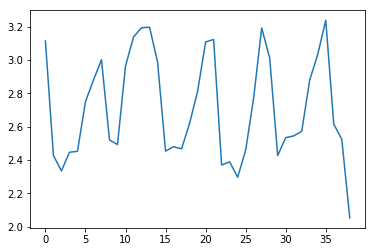

In [30]:
plt.plot(testpreds[129])

In [31]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [32]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.636503   
air_0164b9927d20bcc3_2017-04-23              1.487510   
air_0241aa3964b7f861_2017-04-23              2.521010   
air_0328696196e46f18_2017-04-23              1.795314   
air_034a3d5b40d5b1b1_2017-04-23              3.399909   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.137171  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.426061  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  11.441154  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   5.021367  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  28.961377

In [33]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [34]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [35]:
submission.to_csv("../submission/3002nb_lstm_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')